# Exploring venues in Manila, Philippines

## Introduction 

This project is aimed at identifying venues in Manila, Philippines. The selected venues are restaurants, hotels, cafes and other eat-ins. The ratings and average prices of these venues are extracted using Zomato and Foursquare APIs. Also their location data will be extracted in order to be able to represent them on a map and create ease of access for people that this might help. Tourists are examples.

Also, others like company owners and foodies might find this information usable and of great benefit. So, primarily this projet identify venues based on the venue ratings and the average prices such that the locations fits the budget of the of visitors and also help firms in decision making especially when targeting specific categories of restaurants.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

## Data Sources

To begin with, we will observe Manila on a Map using the folium library.

We will also fetch the data from two different APIs.

**Foursquare API:** We will use the Foursquare API to fetch venues in Manila starting from the middle upto 44 Kilometers in each direction.

**Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

### Manila

Manila is composed of a number of sectors spread across a total area of 42.88 km². There are many venues (especially restaurants, hotels and cafes) which can be explored.

The geopy library is going to be used to extract the latitude and longitude values of Manila

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

from geopy.geocoders import Nominatim

import folium

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Use geopy library to get the latitude and longitude values of Manila City.
address = 'Manila City, Philippines'
geolocator = Nominatim(user_agent = 'Makati_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Makati City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Makati City are 14.5906216, 120.9799696.


The folium library will be used to create a complete map zoomed on Malina. Also a marker will be shown on the coordinates we just identified above. This would give a relatively good look at the center point our case study

In [11]:
LATITUDE = 14.5906216
LONGITUDE = 120.9799696

Manila_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)
folium.Marker([LATITUDE, LONGITUDE]).add_to(Manila_map)
Manila_map.save("maps/TargetMap.html")
Manila_map

### Foursquare API

All venues in Manila upto a range of 5 Kilometers form the center will be fetched using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [17]:
CLIENT_ID = 'LZ3EAHUI2XDRBPUPMUKVFNU1JM020OXF5XT0Q5XZTEVKNMMV' # Foursquare ID
CLIENT_SECRET = 'VU5ETCO1LGHVGJQAJMZLGSEHTCEH2N4NU1X2XIR4KLZSGNAT' # Foursquare Secret
VERSION = '20180604'
LIMIT = 100
RADIUS = 5000 # 5 Km

We define the get_category_type method to get the correct category for each venue.

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

In [23]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        LATITUDE, 
                                                                        LONGITUDE, 
                                                                        RADIUS,
                                                                        LIMIT,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))


Total 100 venues fetched within a total radius of 5.0 Km
Total 100 venues fetched within a total radius of 5.0 Km
Total 32 venues fetched within a total radius of 5.0 Km

Total 232 venues fetched


In [27]:
foursquare_venues.head(20)

,name,categories,lat,lng
0,Adobo Connection,Filipino Restaurant,14.590246,120.982349
1,Coco Bango Cafe,Asian Restaurant,14.589654,120.975609
2,White Knight Hotel,Hotel,14.589625,120.975555
3,San Agustin Church,Church,14.589455,120.974987
4,The French Baker,Bakery,14.590214,120.983140
5,Silahis Art and Artifacts,Antique Shop,14.587427,120.977411
6,Cathedral-Basilica of the Immaculate Conceptio...,Church,14.591568,120.973592
7,98B,Public Art,14.598836,120.979435
8,Manila Hotel,Hotel,14.583350,120.973774
9,Ying Ying Tea House,Chinese Restaurant,14.597885,120.976729


### Zomato API
The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

The name, lat, and lng values of various venues fetched from Foursquare API will be used to use the search API and get more information regarding each venue.

- The **query** is the name of the venue.
- The **start** defines from what offset we want to start, so we'll keep it at 0.
- The **count** defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
- **Latitude** and **longitude** values will be supplied.
- The **sorting criteria** will be real_distance so each time we get the venue we're searching based on location coordinates.

In [22]:
headers = {'user-key': '617e6e315c6ec2ad5234e884957bfa4d'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    try:
        result = requests.get(url, headers = headers).json()
    except:
        print("There was an error...")
    try:
        
        if (len(result['restaurants']) > 0):
            venue.append(result['restaurants'][0]['restaurant']['name'])
            venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
            venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
            venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
            venue.append(result['restaurants'][0]['restaurant']['price_range'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
            venue.append(result['restaurants'][0]['restaurant']['location']['address'])
            venues_information.append(venue)
        else:
            venues_information.append(np.zeros(6))
    except:
        pass
        
ZomatoVenues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [25]:
ZomatoVenues.head(20)

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Barbara's,14.5901172908,120.9766978025,800.0,3.0,3.8,"Plaza San Luis Complex, General Luna Street, I..."
1,Coco Bango Cafe,14.5896705030,120.9756242484,900.0,3.0,3.9,"White Knight Hotel, General Luna Street, Intra..."
2,Coco Bango Cafe,14.5896705030,120.9756242484,900.0,3.0,3.9,"White Knight Hotel, General Luna Street, Intra..."
3,Batala Bar,14.5895014566,120.9750951827,500.0,2.0,0,"Plaza San Luis Complex, General Luna Street, I..."
4,Pancake House,14.5824792674,120.9841167927,500.0,2.0,3.5,"Ground Floor, Times Plaza, U. N. Avenue, Ermit..."
5,Troika Resto & Art Gallery,14.6081892132,120.9930790588,900.0,3.0,3.4,"823 Extremadura Street, Sampaloc, Manila"
6,La Cathedral Cafe,14.5916296140,120.9741101414,600.0,2.0,2.4,"398 Cabildo Corner Beaterio Street, Intramuros..."
7,P3K Cafe,14.6116431498,120.9867101535,200.0,1.0,3.3,"1243-B Navarra Corner Laon Laan Street, Sampal..."
8,Red Jade - Manila Hotel,14.5834611284,120.9739978239,1700.0,4.0,3.9,"The Manila Hotel, One Rizal Park, Ermita, Mani..."
9,Ying Ying,14.5979708104,120.9768463299,800.0,3.0,4.1,"233-235 Dasmarinas Corner Yuchengco Street, Bi..."


### Data Cleaning 
The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

To see what output we have, We'll plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values where necessary. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

The Foursquare data will first be plotted on the map.

In [29]:
Manila_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)
folium.Marker([LATITUDE, LONGITUDE]).add_to(Manila_map)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(Manila_map)  

Manila_map.save("maps/Venues by Foursquare.html")
Manila_map

From the map, we can infer that there are clusters of venues around the coastline - presumably because of the ocean view, Malate, Binondo and Sampaloc. We can also plot the category count and see the major type of venues that exist.


Now, the Zomato data will be plotted on the map.

In [31]:
Manila_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)
folium.Marker([LATITUDE, LONGITUDE]).add_to(Manila_map)

for venue, address, latitude, longitude in zip(ZomatoVenues['venue'], ZomatoVenues['address'], 
                                               ZomatoVenues['latitude'], ZomatoVenues['longitude']):
    UPDATED_LG = float(longitude)
    UPDATED_LT = float(latitude)
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [UPDATED_LT, UPDATED_LG],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(Manila_map)  

Manila_map.save("maps/Venues by Zomato.html")
Manila_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two near coastline, Malate, Binondo and Sampaloc. However, there are others where the data does not match just like the red dots in the bottom right on the second map.

To combine the two datasets, we'll have to check that the latitude and longitude values of each corresponding venue match. Thus, we'll round both the latitude and longitude values up to 4 decimal places then calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004. If this is the case, it should ideally means that the two locations are same.

In [33]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
ZomatoVenues['latitude'] = ZomatoVenues['latitude'].apply(lambda lat: round(float(lat), 4))
ZomatoVenues['longitude'] = ZomatoVenues['longitude'].apply(lambda lng: round(float(lng), 4))

In [34]:
dataset = pd.concat([foursquare_venues, ZomatoVenues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [44]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
print('There are {} restaurants selected'.format(len(selected_venues.index)))
print('\n')
selected_venues.head(20)

There are 115 restaurants selected




,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Coco Bango Cafe,Asian Restaurant,14.5897,120.9756,Coco Bango Cafe,14.5897,120.9756,900.0,3.0,3.9,"White Knight Hotel, General Luna Street, Intra...",0.0000,0.0000
1,White Knight Hotel,Hotel,14.5896,120.9756,Coco Bango Cafe,14.5897,120.9756,900.0,3.0,3.9,"White Knight Hotel, General Luna Street, Intra...",0.0001,0.0000
2,San Agustin Church,Church,14.5895,120.9750,Batala Bar,14.5895,120.9751,500.0,2.0,0,"Plaza San Luis Complex, General Luna Street, I...",0.0000,0.0001
3,Manila Hotel,Hotel,14.5833,120.9738,Red Jade - Manila Hotel,14.5835,120.9740,1700.0,4.0,3.9,"The Manila Hotel, One Rizal Park, Ermita, Mani...",0.0002,0.0002
4,Ying Ying Tea House,Chinese Restaurant,14.5979,120.9767,Ying Ying,14.5980,120.9768,800.0,3.0,4.1,"233-235 Dasmarinas Corner Yuchengco Street, Bi...",0.0001,0.0001
5,Minor Basilica of St. Lorenzo Ruiz of Manila (...,Church,14.5999,120.9746,Five Spice - Ramada Manila Central,14.6001,120.9749,1500.0,4.0,3.4,"Ramada Manila Central, Ongpin Corridor, Quinti...",0.0002,0.0003
6,Tim Hortons,Coffee Shop,14.5834,120.9870,Tim Hortons,14.5832,120.9872,500.0,2.0,4.1,"U.N. Square Mall, San Marcelino Street Corner ...",-0.0002,0.0002
7,San Agustin Museum,Monument / Landmark,14.5894,120.9750,Batala Bar,14.5895,120.9751,500.0,2.0,0,"Plaza San Luis Complex, General Luna Street, I...",0.0001,0.0001
8,The Den,Coffee Shop,14.5988,120.9794,The Den,14.5990,120.9794,700.0,3.0,4.0,"First United Building, 413 Escolta Street, Bin...",0.0002,0.0000
9,Tasty Dumplings,Chinese Restaurant,14.6036,120.9763,Tasty Dumplings,14.6035,120.9764,500.0,2.0,3.9,"960 Masangkay Street, Binondo, Manila",-0.0001,0.0001


It is observed that some venues have the same longitude and latitude values. For these set of venues, we will assume that they are in the same building/ complex. This type of scenerio is not uncommon in the phillipines, hence no deletion will be made as sources of data are reliable and up-to-date.

Now, venues that have 0.0 rating will be dropped as it means it's not been rated yet.

In [45]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 100


I'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [ ]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [61]:
selected_venues.head()

,categories,venue,latitude,longitude,price_range,rating,address,rating_bin,average_price
0,Asian Restaurant,Coco Bango Cafe,14.5897,120.9756,3.0,3.9,"White Knight Hotel, General Luna Street, Intra...",Good,450.0
1,Hotel,Coco Bango Cafe,14.5897,120.9756,3.0,3.9,"White Knight Hotel, General Luna Street, Intra...",Good,450.0
3,Hotel,Red Jade - Manila Hotel,14.5835,120.9740,4.0,3.9,"The Manila Hotel, One Rizal Park, Ermita, Mani...",Good,850.0
4,Chinese Restaurant,Ying Ying,14.5980,120.9768,3.0,4.1,"233-235 Dasmarinas Corner Yuchengco Street, Bi...",Very good,400.0
5,Church,Five Spice - Ramada Manila Central,14.6001,120.9749,4.0,3.4,"Ramada Manila Central, Ongpin Corridor, Quinti...",Good,750.0


## Methodology 
This project aims at identifying the venues in Manila based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, data was retrieved from two APIs (Foursquare and Zomato). The venues information was also extracted from the center of Makati, upto a distance of 5 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are highly rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis 
The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue is based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

### Grouping by Categories
We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 38 artists>

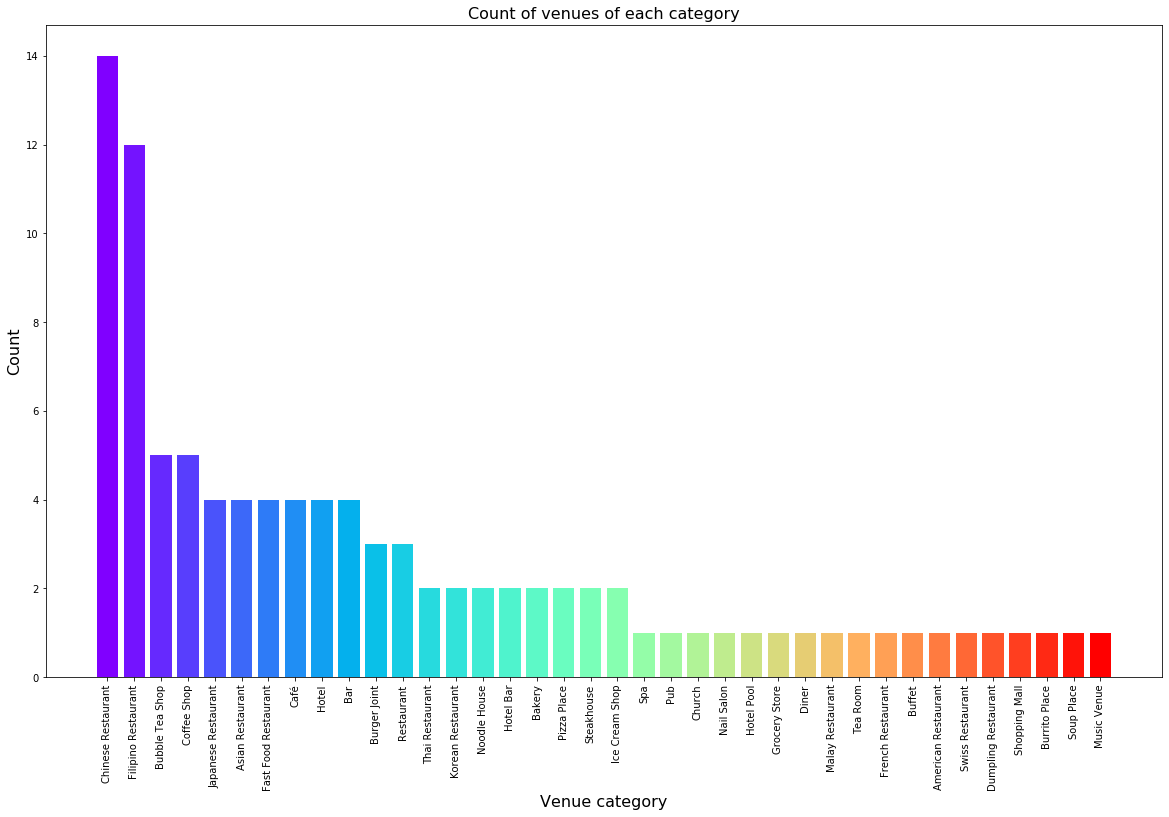

In [46]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can depict from the histogram, the majority venues are Chinese and Filipino Restaurant. Ideally, we can say Manilla is a welcoming place for Chinese tourists and lovers of Chinese food.

### Grouping by Ratings

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To put this in consideration, we will first see what the average rating for all the venues in the city are. Next, we will plot the venues on the map and color code them.

We'll identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

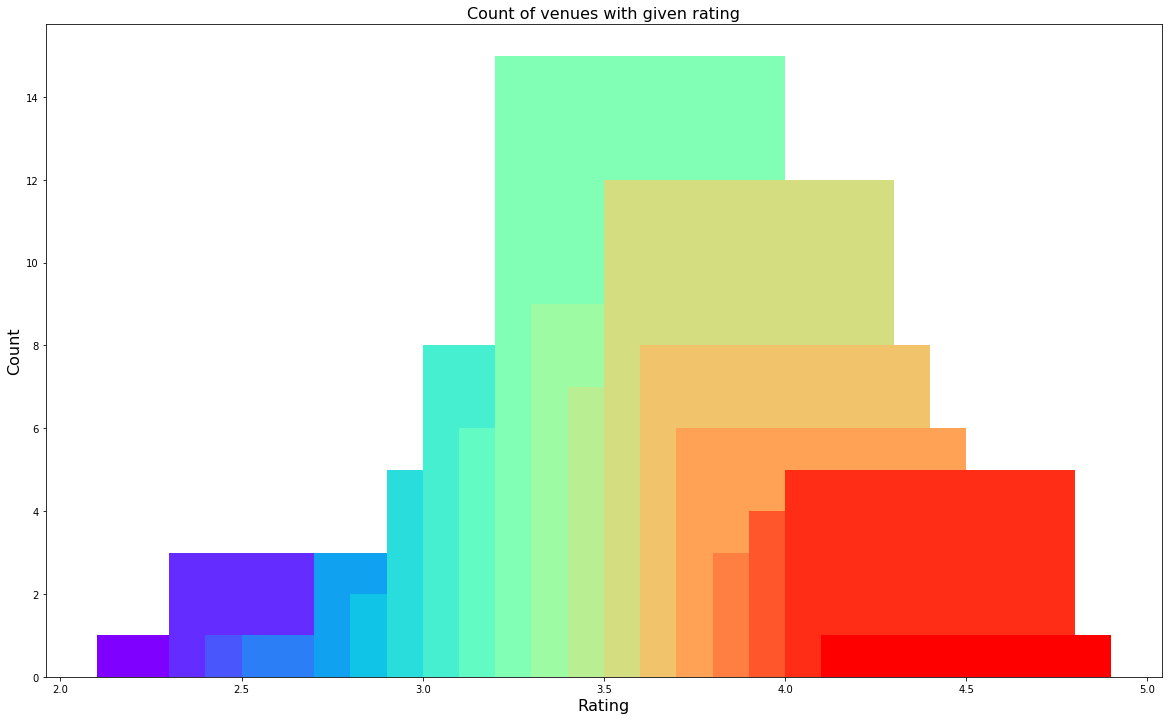

In [47]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that **majority of the venues** have their rating close to **3.5**.

Bins will be created for various ratings and plotted them in different colors on the map. The ratings will be divided between 4 bins:

- 1 to 2
- 2 to 3
- 3 to 4
- 4 to 5

In [49]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Let's see if the bins have been added

In [58]:
selected_venues['rating_bin'].unique()

[Good, Very good, Okay]
Categories (3, object): [Okay < Good < Very good]

Good. Now plot the venues on the map

In [54]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

target_location_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(Manila_map)  

Manila_map.save("maps/Venues Ratings.html")
Manila_map

The map has the location of all the venues. It appears that most of the venues have ratings above 3.0. However, 2 restaurants have rating values that are lesser than 3.0 in San Teresita and one in Santa Cruz.

### Price

The venues will be categorized based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

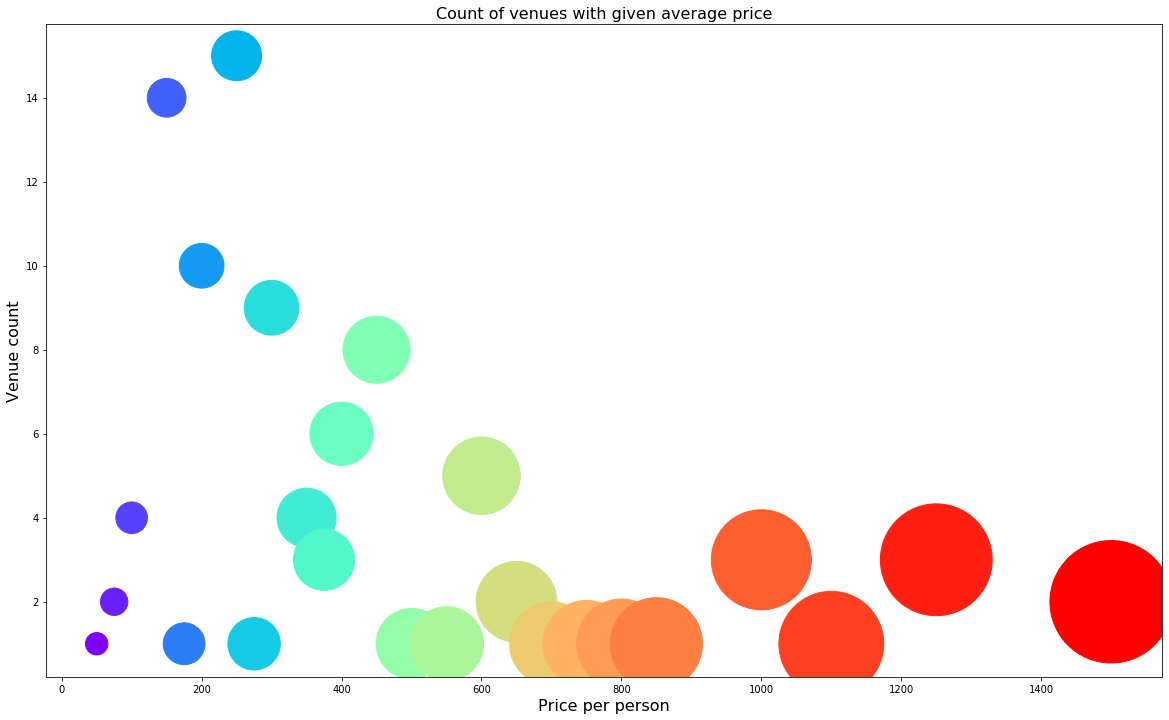

In [62]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between PHP400 and PHP700.

Now, we use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [79]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

Manila_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                         selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(Manila_map)  

Manila_map.save("maps/Venues Prices.html")
Manila_map

From the map, the expensive venues are along the coast line or close to the sea. The middle price ranges are seen to be clustered around Sampaloc. Other places around this location have moderate prices also.

### Clustering

We will now cluster these venues based on their price range, location and more to identify similar venues and the relationship among them. We'll cluster the venues into two groups.

In [68]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,rating_bin,average_price
0,0,Asian Restaurant,Coco Bango Cafe,14.5897,120.9756,3.0,3.9,"White Knight Hotel, General Luna Street, Intra...",Good,450.0
1,0,Hotel,Coco Bango Cafe,14.5897,120.9756,3.0,3.9,"White Knight Hotel, General Luna Street, Intra...",Good,450.0
3,1,Hotel,Red Jade - Manila Hotel,14.5835,120.9740,4.0,3.9,"The Manila Hotel, One Rizal Park, Ermita, Mani...",Good,850.0
4,0,Chinese Restaurant,Ying Ying,14.5980,120.9768,3.0,4.1,"233-235 Dasmarinas Corner Yuchengco Street, Bi...",Very good,400.0
5,1,Church,Five Spice - Ramada Manila Central,14.6001,120.9749,4.0,3.4,"Ramada Manila Central, Ongpin Corridor, Quinti...",Good,750.0


In [69]:
Manila_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(Manila_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(Manila_map)

Manila_map.save("maps/Venues Clusters.html")
Manila_map

From the map, we see the two clusters:

* The first cluster is spread across the whole city and includes the majority venues.
* The second cluster is very sparsely spread and has very limited venues.

Let's check the venues of the two clusters.

#### For the first cluster

In [71]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,rating_bin,average_price
0,0,Asian Restaurant,Coco Bango Cafe,14.5897,120.9756,3.0,3.9,"White Knight Hotel, General Luna Street, Intra...",Good,450.0
1,0,Hotel,Coco Bango Cafe,14.5897,120.9756,3.0,3.9,"White Knight Hotel, General Luna Street, Intra...",Good,450.0
2,0,Chinese Restaurant,Ying Ying,14.5980,120.9768,3.0,4.1,"233-235 Dasmarinas Corner Yuchengco Street, Bi...",Very good,400.0
3,0,Coffee Shop,Tim Hortons,14.5832,120.9872,2.0,4.1,"U.N. Square Mall, San Marcelino Street Corner ...",Very good,250.0
4,0,Coffee Shop,The Den,14.5990,120.9794,3.0,4.0,"First United Building, 413 Escolta Street, Bin...",Good,350.0
5,0,Chinese Restaurant,Tasty Dumplings,14.6035,120.9764,2.0,3.9,"960 Masangkay Street, Binondo, Manila",Good,250.0
6,0,Chinese Restaurant,Wai Ying Fastfood,14.6072,120.9785,2.0,3.9,"1237-1241 Benavidez Street, Tondo, Manila",Good,300.0
7,0,Japanese Restaurant,Pepper Lunch Express,14.6029,120.9738,2.0,3.4,"Food Junction, Fourth Floor, Lucky Chinatown M...",Good,250.0
8,0,Chinese Restaurant,Wai Ying Fastfood,14.6020,120.9760,2.0,4.4,"810 Benavidez Street, Binondo, Manila",Very good,300.0
9,0,Chinese Restaurant,Ang Tunay Beef House,14.6011,120.9771,2.0,3.6,"825 Sabino Padilla Street, Binondo, Manila",Good,250.0


In [73]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 2.10 and rating spread around 3.69


#### For the second cluster

In [77]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,rating_bin,average_price
0,1,Hotel,Red Jade - Manila Hotel,14.5835,120.9740,4.0,3.9,"The Manila Hotel, One Rizal Park, Ermita, Mani...",Good,850.0
1,1,Church,Five Spice - Ramada Manila Central,14.6001,120.9749,4.0,3.4,"Ramada Manila Central, Ongpin Corridor, Quinti...",Good,750.0
2,1,Bar,Tap Station,14.5775,120.9819,4.0,3.6,"1313 Adriatico Corner Padre Faura Street, Ermi...",Good,700.0
3,1,Filipino Restaurant,Casa Roces,14.5935,120.9930,4.0,4.3,"1153 JP Laurel corner Aguado Street, San Migue...",Very good,1000.0
4,1,Restaurant,Corniche - Diamond Hotel,14.5723,120.9823,4.0,4.1,"Diamond Hotel, Roxas Boulevard Corner J. Quint...",Very good,1250.0
5,1,Hotel Bar,Bar 27 - Diamond Hotel,14.5724,120.9826,4.0,3.1,"27th Floor, Diamond Hotel, Roxas Boulevard Cor...",Good,1000.0
6,1,Japanese Restaurant,Tanabe,14.5706,120.9862,4.0,4.0,"553 Remedios Street, Malate, Manila",Good,1000.0
7,1,Buffet,Sunset Bar - Sofitel Philippine Plaza Manila,14.5529,120.9808,4.0,3.8,"Pool Area, Sofitel Philippine Plaza Manila, CC...",Good,1500.0
8,1,Hotel Pool,Le Bar - Sofitel Philippine Plaza Manila,14.5531,120.9801,4.0,3.9,"Lobby Level, Sofitel Philippine Plaza Manila, ...",Good,1250.0
9,1,Hotel Bar,Le Bar - Sofitel Philippine Plaza Manila,14.5531,120.9801,4.0,3.9,"Lobby Level, Sofitel Philippine Plaza Manila, ...",Good,1250.0


In [78]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 3.76


# Results and Discussion

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Manila, Philippines.

After collecting data from the Foursquare and Zomato APIs, we got a list of 232 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 100.

We identified that from the total set of venues, majority of them were Chinese Restaurants and then Fillipino Restaurants follows. A visitor who loves Chinese and Filipino foods would surely want Manila as a resident city.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues close to the sea. This means that anyone that gets a residential apartment close to the water body will definitely enjoy good food. However, the budget of the person might be a limiting factor which takes us to the next insight.

When observe the price values of each venue, we explore that many venues have prices which are in the range of PHP400 to PHP700 for one person. However, the variation in prices is very large, given the complete range starts from PHP100 and goes uptil PHP1600. On plotting the venues based on their price range on the map, we discovered that venues located near the coastline are relatively priced higher than those far from it.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.69. On the other hand, there are few venues which are high priced and have average rating of 3.76.

If you're looking for cheap places with relatively high rating, you should check San Isidro Labrador.
If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit Binando and Malate
A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

## Conclusion

The purpose of this project was to explore the places that a person visiting Manila could visit or stay. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit or stay: San Isidro Labrador, Binondo and Malate. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.